In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re 
from glob import glob
from os.path import join
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
from circuit_toolkit.plot_utils import saveallforms

/n/home12/binxuwang/Github/circuit_toolkit/circuit_toolkit/GAN_invert_utils.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


In [3]:
import sys 
sys.path.append("/n/home12/binxuwang/Github/DiffusionReasoning")
from tensorboard_utils import extract_all_runs, extract_tensorboard_data_from_run, extract_last_step_summary, extract_last_K_step_avg_summary
from rule_new_utils import rule_table, relation_dict, attribute_dict, rule_table_brief, relation_dict_brief
from stats_plot_utils import add_rectangles

In [4]:
from posthoc_analysis_utils import sweep_collect_eval_data, extract_rule_list_from_eval_col_Diffusion, format_rule_list_to_mat, visualize_indiv_rule_dynam, extract_and_convert

In [5]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
figroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_inpainting"
synopsis_dir = join(figroot, "synopsis")

In [6]:
!echo {exproot}/090-RAVEN10_abstract*

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204


In [11]:
heldout_ids = [1, 16, 20, 34, 37]
heldout_mask = np.zeros(40, dtype=bool)
heldout_mask[heldout_ids] = 1

## Dissection of one training run case

In [7]:
expname = "090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
outdir = join(expdir, "inpainting_results")
figexpdir = join(figroot, expname)

In [8]:
pklpaths = glob(join(outdir, "inpaint_stats_*.pkl"))
df_all = []
for pklpath in pklpaths:
    print(pklpath)
    # extract savestr from pklpath
    savestr = re.search(r"inpaint_stats_(.*).pkl", pklpath).group(1)
    match = re.search(r"inpaint_stats_ep(\d+)_(\d+)_(\d+)_batch(\d+)\.pkl", pklpath)
    epoch, sample_beg, sample_end, batch = match.groups()
    epoch, sample_beg, sample_end, batch = int(epoch), int(sample_beg), int(sample_end), int(batch)
    inpaint_stats_df = pd.read_pickle(pklpath)
    # inpaint_stats_df = pd.read_pickle(join(outdir, f"inpaint_stats_{savestr}.pkl"))
    inpaint_stats_df["epoch"] = epoch
    df_all.append(inpaint_stats_df)
    # results_col = pkl.load(open(join(outdir, f"inpaint_results_{savestr}.pkl"), "rb"))
df_all = pd.concat(df_all, axis=0)

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/inpainting_results/inpaint_stats_ep100000_50_100_batch25.pkl
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/inpainting_results/inpaint_stats_ep500000_50_100_batch25.pkl
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/inpainting_results/inpaint_stats_ep1000000_50_100_batch25.pkl
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/inpainting_results/inpaint_stats_ep200000_50_100_batch25.pkl
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0

In [9]:
df_all.to_csv(join(figexpdir, "inpaint_epoch_combined.csv"), index=False)
df_all.to_csv(join(synopsis_dir, "inpaint_epoch_combined.csv"), index=False)

In [10]:
df_all.head()

,rule_id,sample_id,inpaint_acc,valid_acc,epoch
0,0,50,0.0,0.0,100000
1,0,51,1.0,1.0,100000
2,0,52,0.0,0.0,100000
3,0,53,0.0,1.0,100000
4,0,54,0.0,0.0,100000


### Rule heatmap

In [21]:
figexpdir

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_inpainting/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204'

In [25]:
savestr

'ep900000_50_100_batch25'

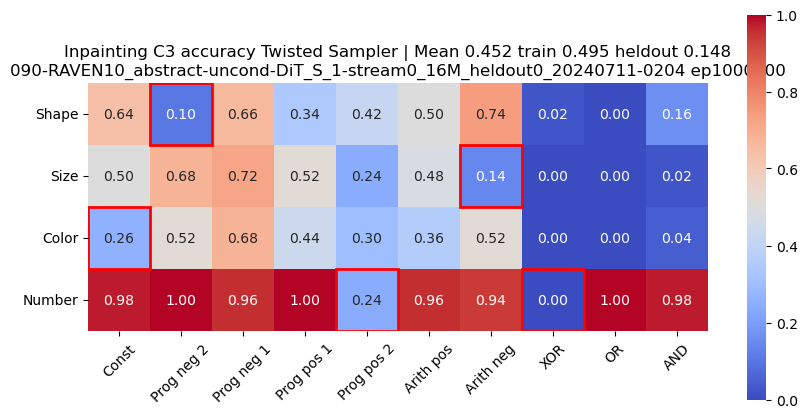

In [26]:
epoch = 1000000
inpaint_acc_tab = df_all.query(f"epoch == {epoch}").groupby("rule_id").agg({"inpaint_acc": "mean", "valid_acc": "mean", })
mean_acc = inpaint_acc_tab["inpaint_acc"].mean()
trained_acc = inpaint_acc_tab["inpaint_acc"].values[~heldout_mask].mean()
heldout_acc = inpaint_acc_tab["inpaint_acc"].values[heldout_mask].mean()
plt.figure(figsize=(10, 5))
sns.heatmap(inpaint_acc_tab["inpaint_acc"].values.reshape(4,10), 
            cmap="coolwarm", annot=True, fmt=".2f")
plt.axis("image")
add_rectangles(heldout_ids)
plt.xticks(np.arange(10)+0.5, [relation_dict_brief[i] for i in range(10)], rotation=45)
plt.yticks(np.arange(4)+0.5, [attribute_dict[i] for i in range(4)], rotation=0)
plt.title(f"Inpainting C3 accuracy Twisted Sampler | Mean {mean_acc:.3f} train {trained_acc:.3f} heldout {heldout_acc:.3f}\n{expname} ep{epoch}")
saveallforms([outdir, figexpdir], f"inpainting_C3_acc_rule_heatmap_ep{epoch}_coolwarm")
plt.show()

### Rule split learning dynamics of inpainting

In [29]:
heldout_ids = [1, 16, 20, 34, 37]
df_all["heldout_rule"] = df_all.rule_id.map(lambda x: x in heldout_ids) # & df_syn.heldout

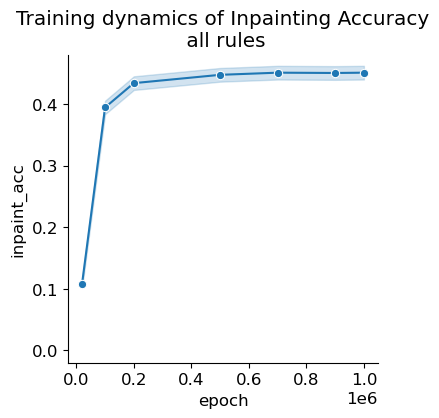

In [94]:
figh, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.lineplot(data=df_all, x="epoch", y="inpaint_acc", 
             errorbar="se", marker="o") # hue="rule_id", 
ax.set_ylim(-0.02, None)
# adding baseline? 
plt.title(f"Training dynamics of Inpainting Accuracy\n all rules")
saveallforms(figexpdir, "inpainting_acc_dynamics_allrules", figh)
plt.show()

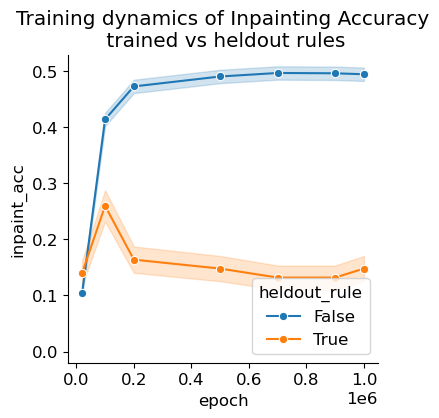

In [93]:
figh, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.lineplot(data=df_all, x="epoch", y="inpaint_acc", hue="heldout_rule", 
             errorbar="se", marker="o") # hue="rule_id", 
ax.set_ylim(-0.02, None)
# adding baseline? 
plt.title(f"Training dynamics of Inpainting Accuracy\n trained vs heldout rules")
saveallforms(figexpdir, "inpainting_acc_dynamics_train_vs_heldout", figh)
plt.show()

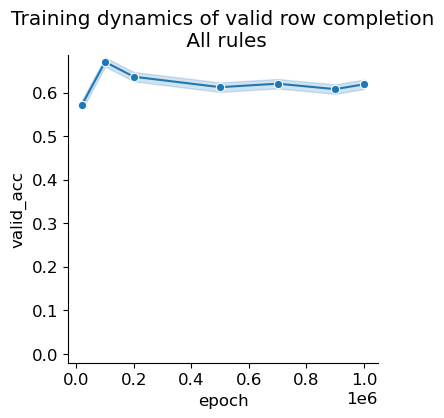

In [99]:
figh, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.lineplot(data=df_all, x="epoch", y="valid_acc",  
             errorbar="se", marker="o") # hue="rule_id", 
ax.set_ylim(-0.02, None)
# adding baseline? 
plt.title(f"Training dynamics of valid row completion\n All rules")
saveallforms(figexpdir, "inpainting_validrow_acc_dynamics_allrules", figh)
plt.show()

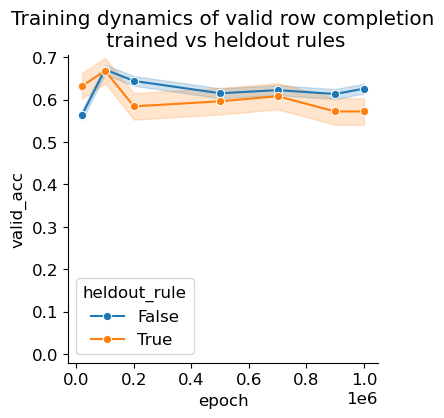

In [98]:
figh, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.lineplot(data=df_all, x="epoch", y="valid_acc", hue="heldout_rule", 
             errorbar="se", marker="o") # hue="rule_id", 
ax.set_ylim(-0.02, None)
# adding baseline? 
plt.title(f"Training dynamics of valid row completion\n trained vs heldout rules")
saveallforms(figexpdir, "inpainting_validrow_acc_dynamics_train_vs_heldout", figh)
plt.show()

In [96]:
list(df_all)

['rule_id', 'sample_id', 'inpaint_acc', 'valid_acc', 'epoch', 'heldout_rule']

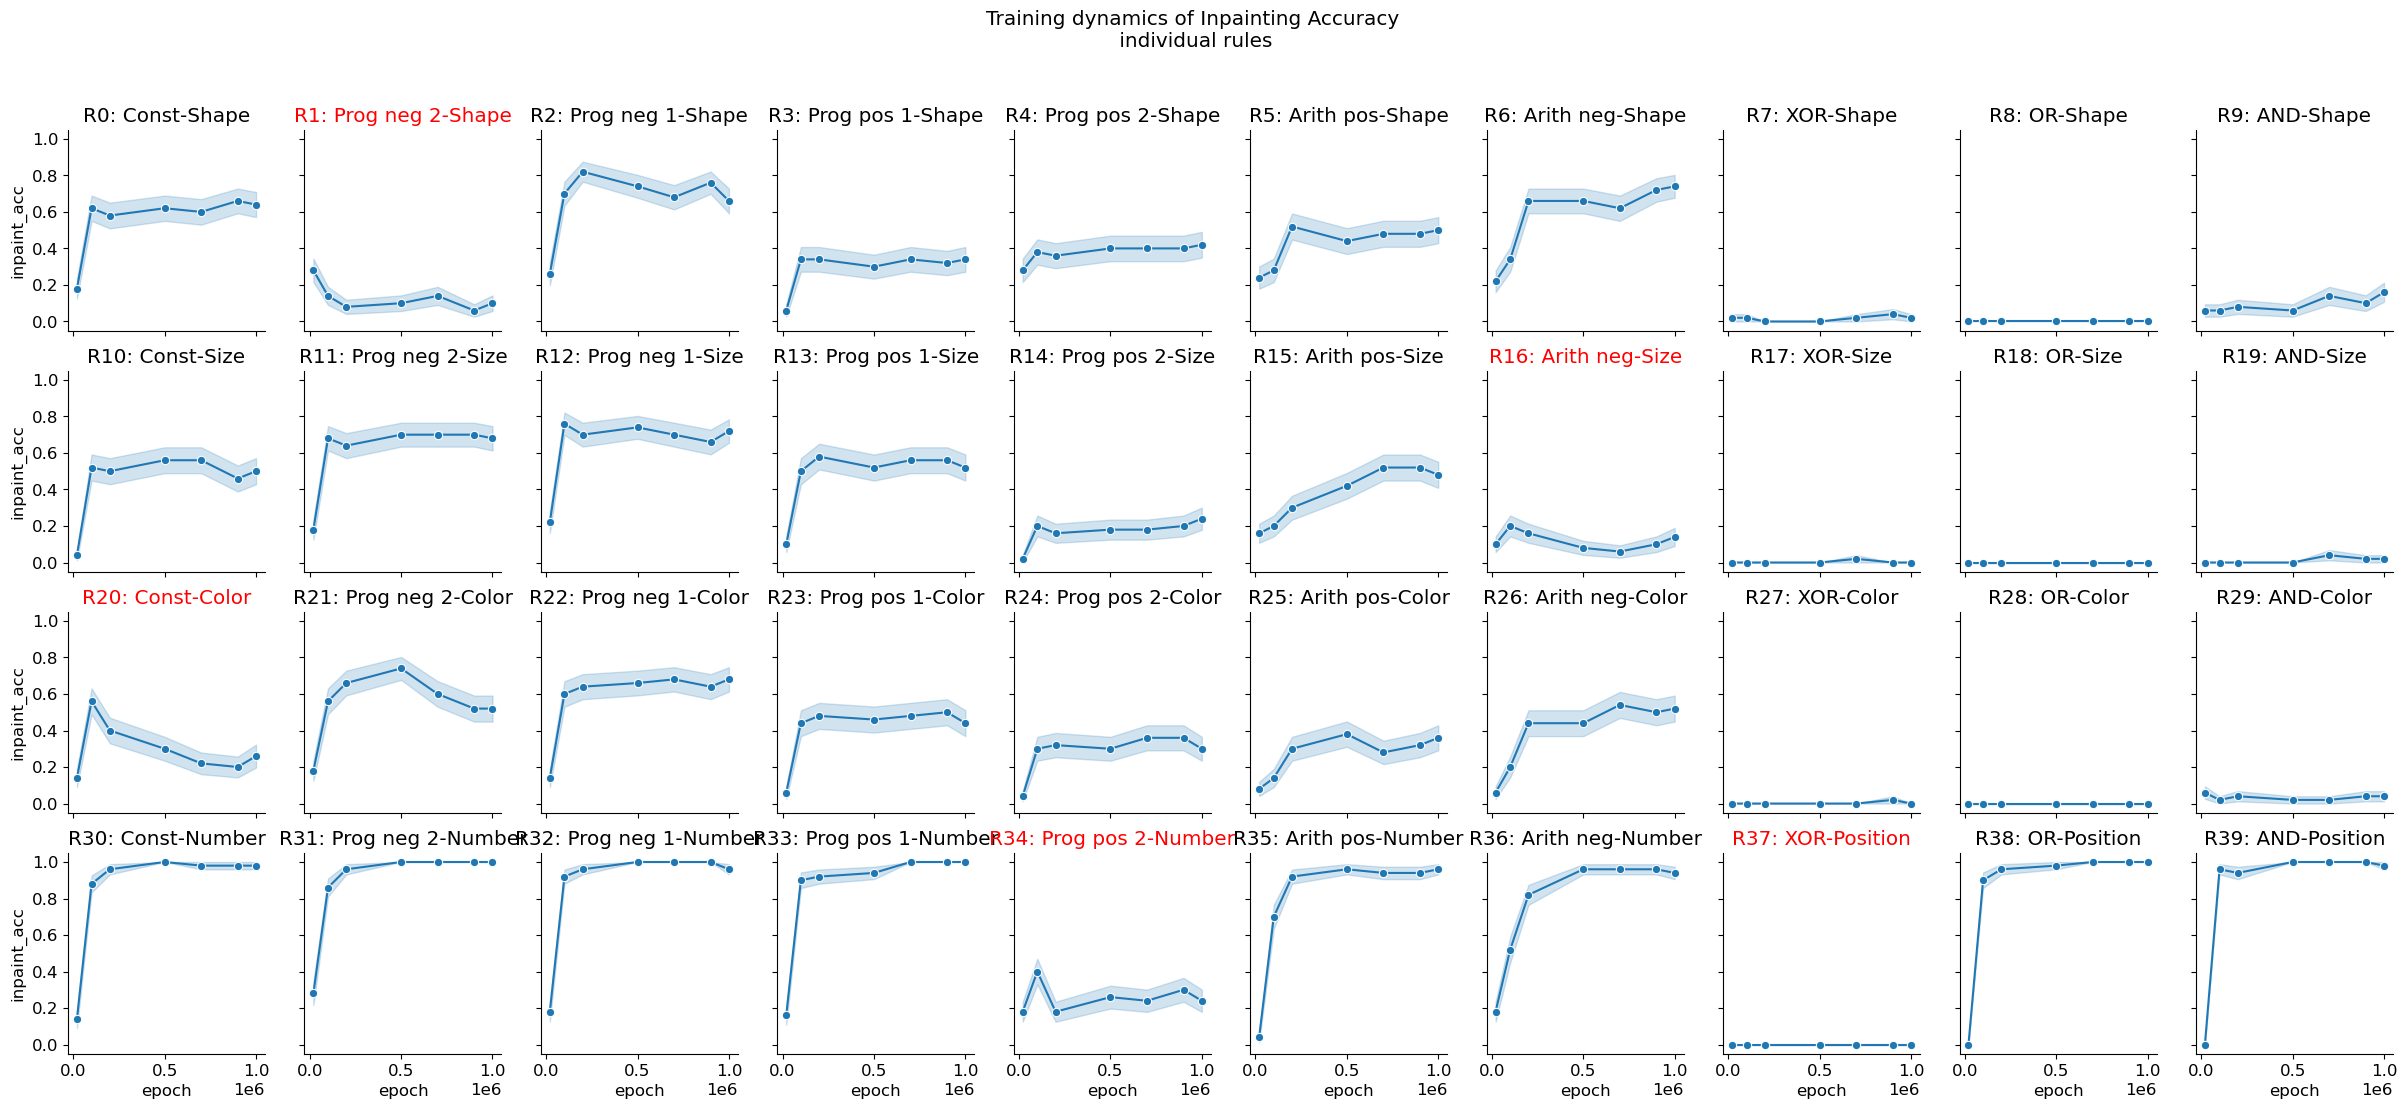

In [100]:
figh, axs = plt.subplots(4, 10, figsize=(30, 12), sharex=True, sharey=True)
axs = axs.flatten()
for i in range(40):
    ax = axs[i]
    sns.lineplot(data=df_all[df_all["rule_id"]==i], x="epoch", y="inpaint_acc", ax=ax, errorbar="se", marker="o") # hue="rule_id", 
    ax.set_ylim(-0.05, 1.05)
    ax.set_title(f"R{i}: {rule_table_brief[i]}")
    # change the font color of title to red
    if i in heldout_ids:
        ax.title.set_color('red')
plt.suptitle("Training dynamics of Inpainting Accuracy\n individual rules")
saveallforms(figexpdir, "inpainting_acc_dynamics_indiv_rules", figh)
plt.show()

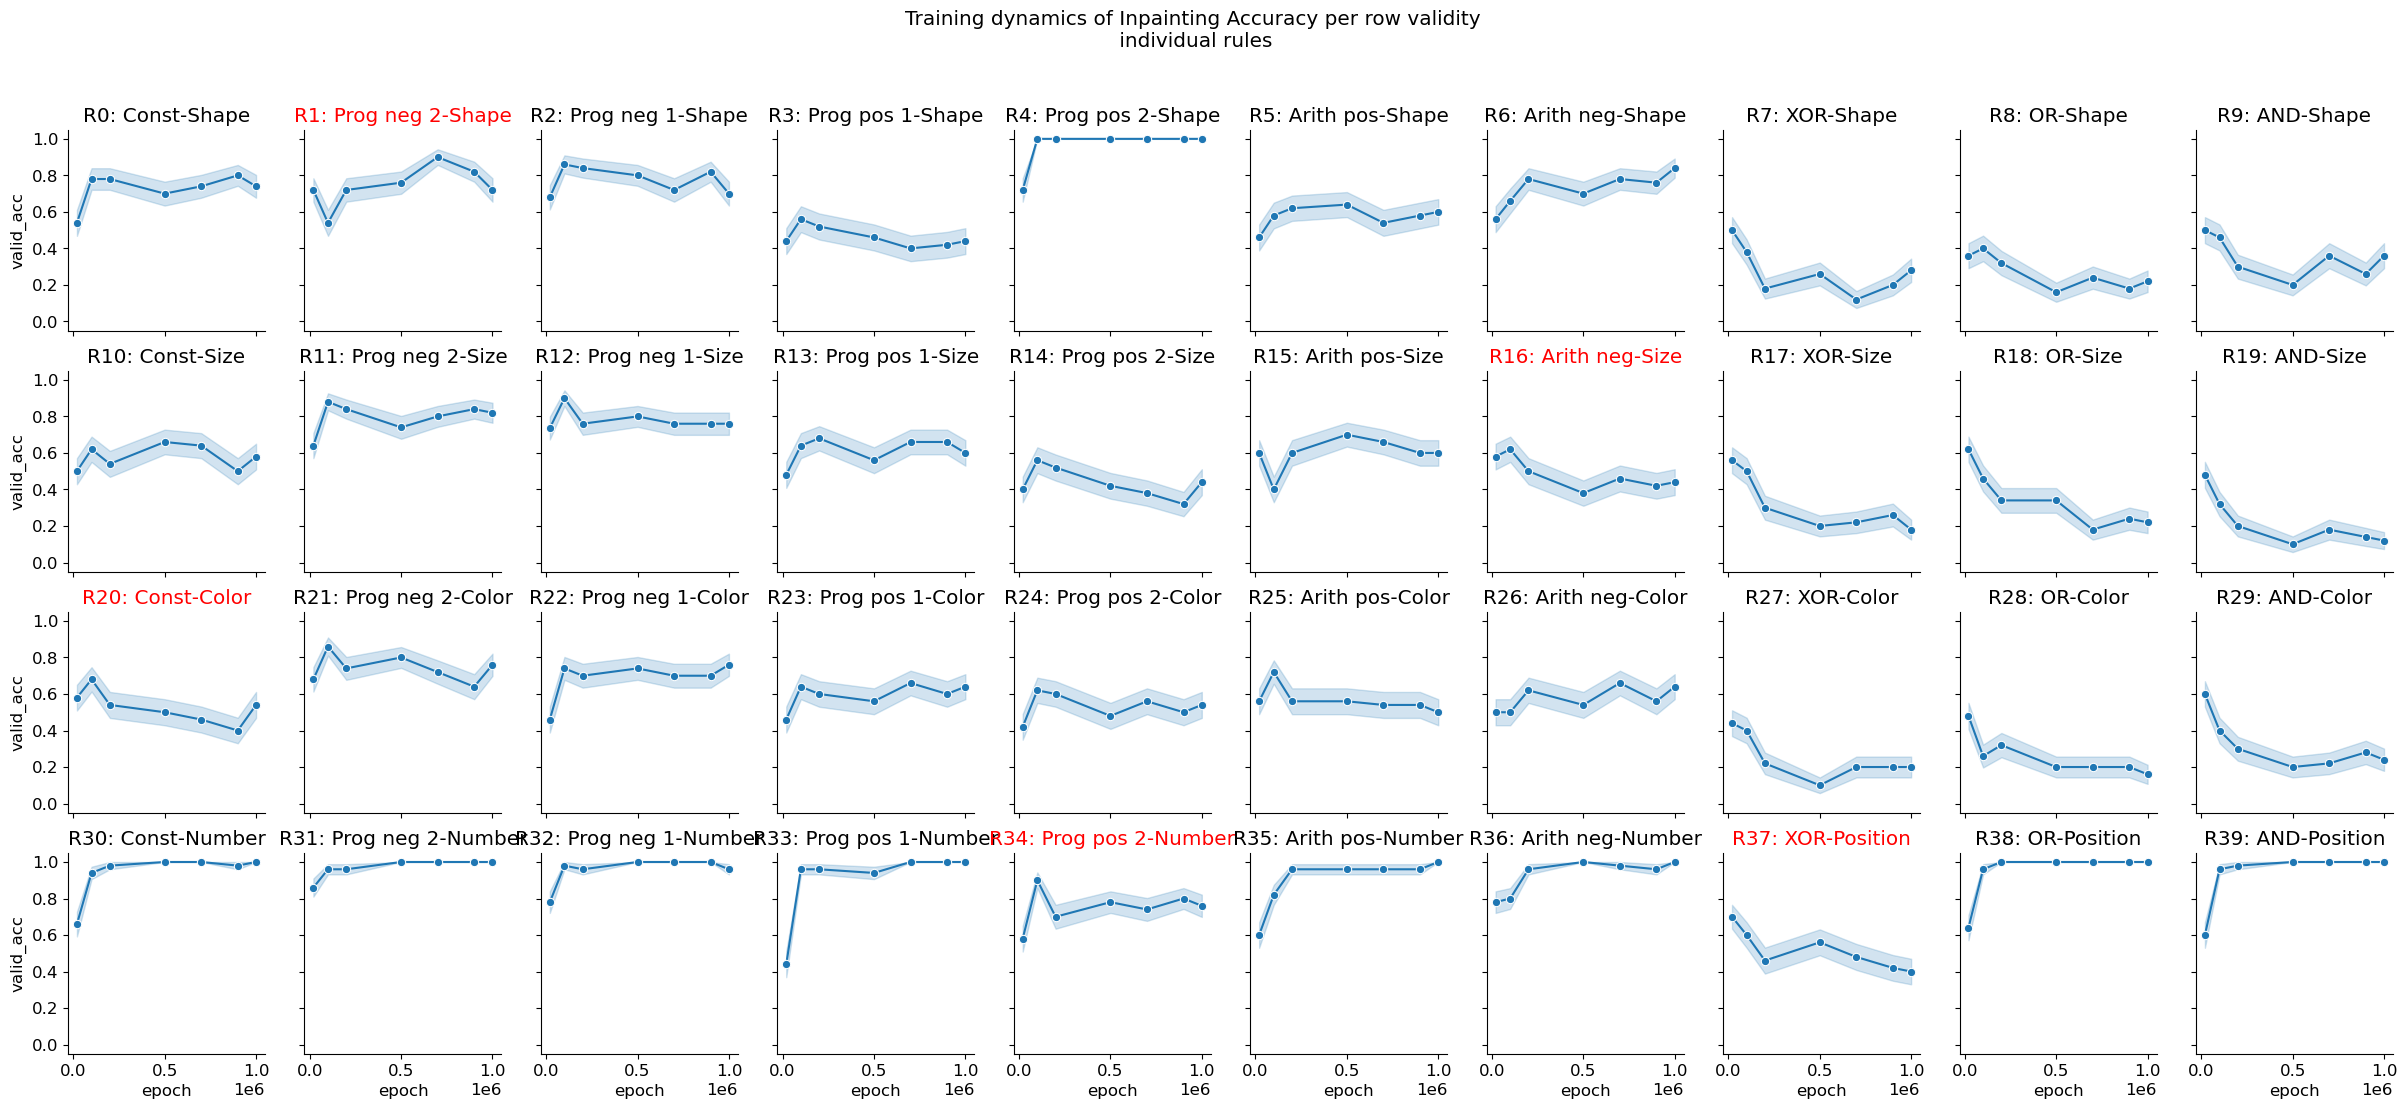

In [101]:
figh, axs = plt.subplots(4, 10, figsize=(30, 12), sharex=True, sharey=True)
axs = axs.flatten()
for i in range(40):
    ax = axs[i]
    sns.lineplot(data=df_all[df_all["rule_id"]==i], x="epoch", y="valid_acc", ax=ax, errorbar="se", marker="o") # hue="rule_id", 
    ax.set_ylim(-0.05, 1.05)
    ax.set_title(f"R{i}: {rule_table_brief[i]}")
    # change the font color of title to red
    if i in heldout_ids:
        ax.title.set_color('red')
plt.suptitle("Training dynamics of Inpainting Accuracy per row validity\n individual rules")
saveallforms(figexpdir, "validrow_acc_dynamics_indiv_rules", figh)
plt.show()

### Comparing conditional vs unconditional generation

In [ ]:
# for expfullname in syndf_SiT.full_name:
    # tb_record = tb_data_col_SiT[expfullname]
    # expname = expfullname.split("/tensorboard_logs")[0]
prefix = "sample_rule_eval_" #"eval_step" if "stream" in expname else "eval_epoch"
eval_col = sweep_collect_eval_data(expname, exproot, prefix=prefix)
epoch_list, rule_list_all, consistency_all = extract_rule_list_from_eval_col_Diffusion(eval_col, )
rule_cnt_mat, cons3_rule_cnt_mat, cons2_rule_cnt_mat = format_rule_list_to_mat(rule_list_all, consistency_all)
eval_sample_num = rule_list_all.shape[1]
print(expname)
if "heldout0" in expname:
    heldout_id = [1, 16, 20, 34, 37]  
else:
    heldout_id = []

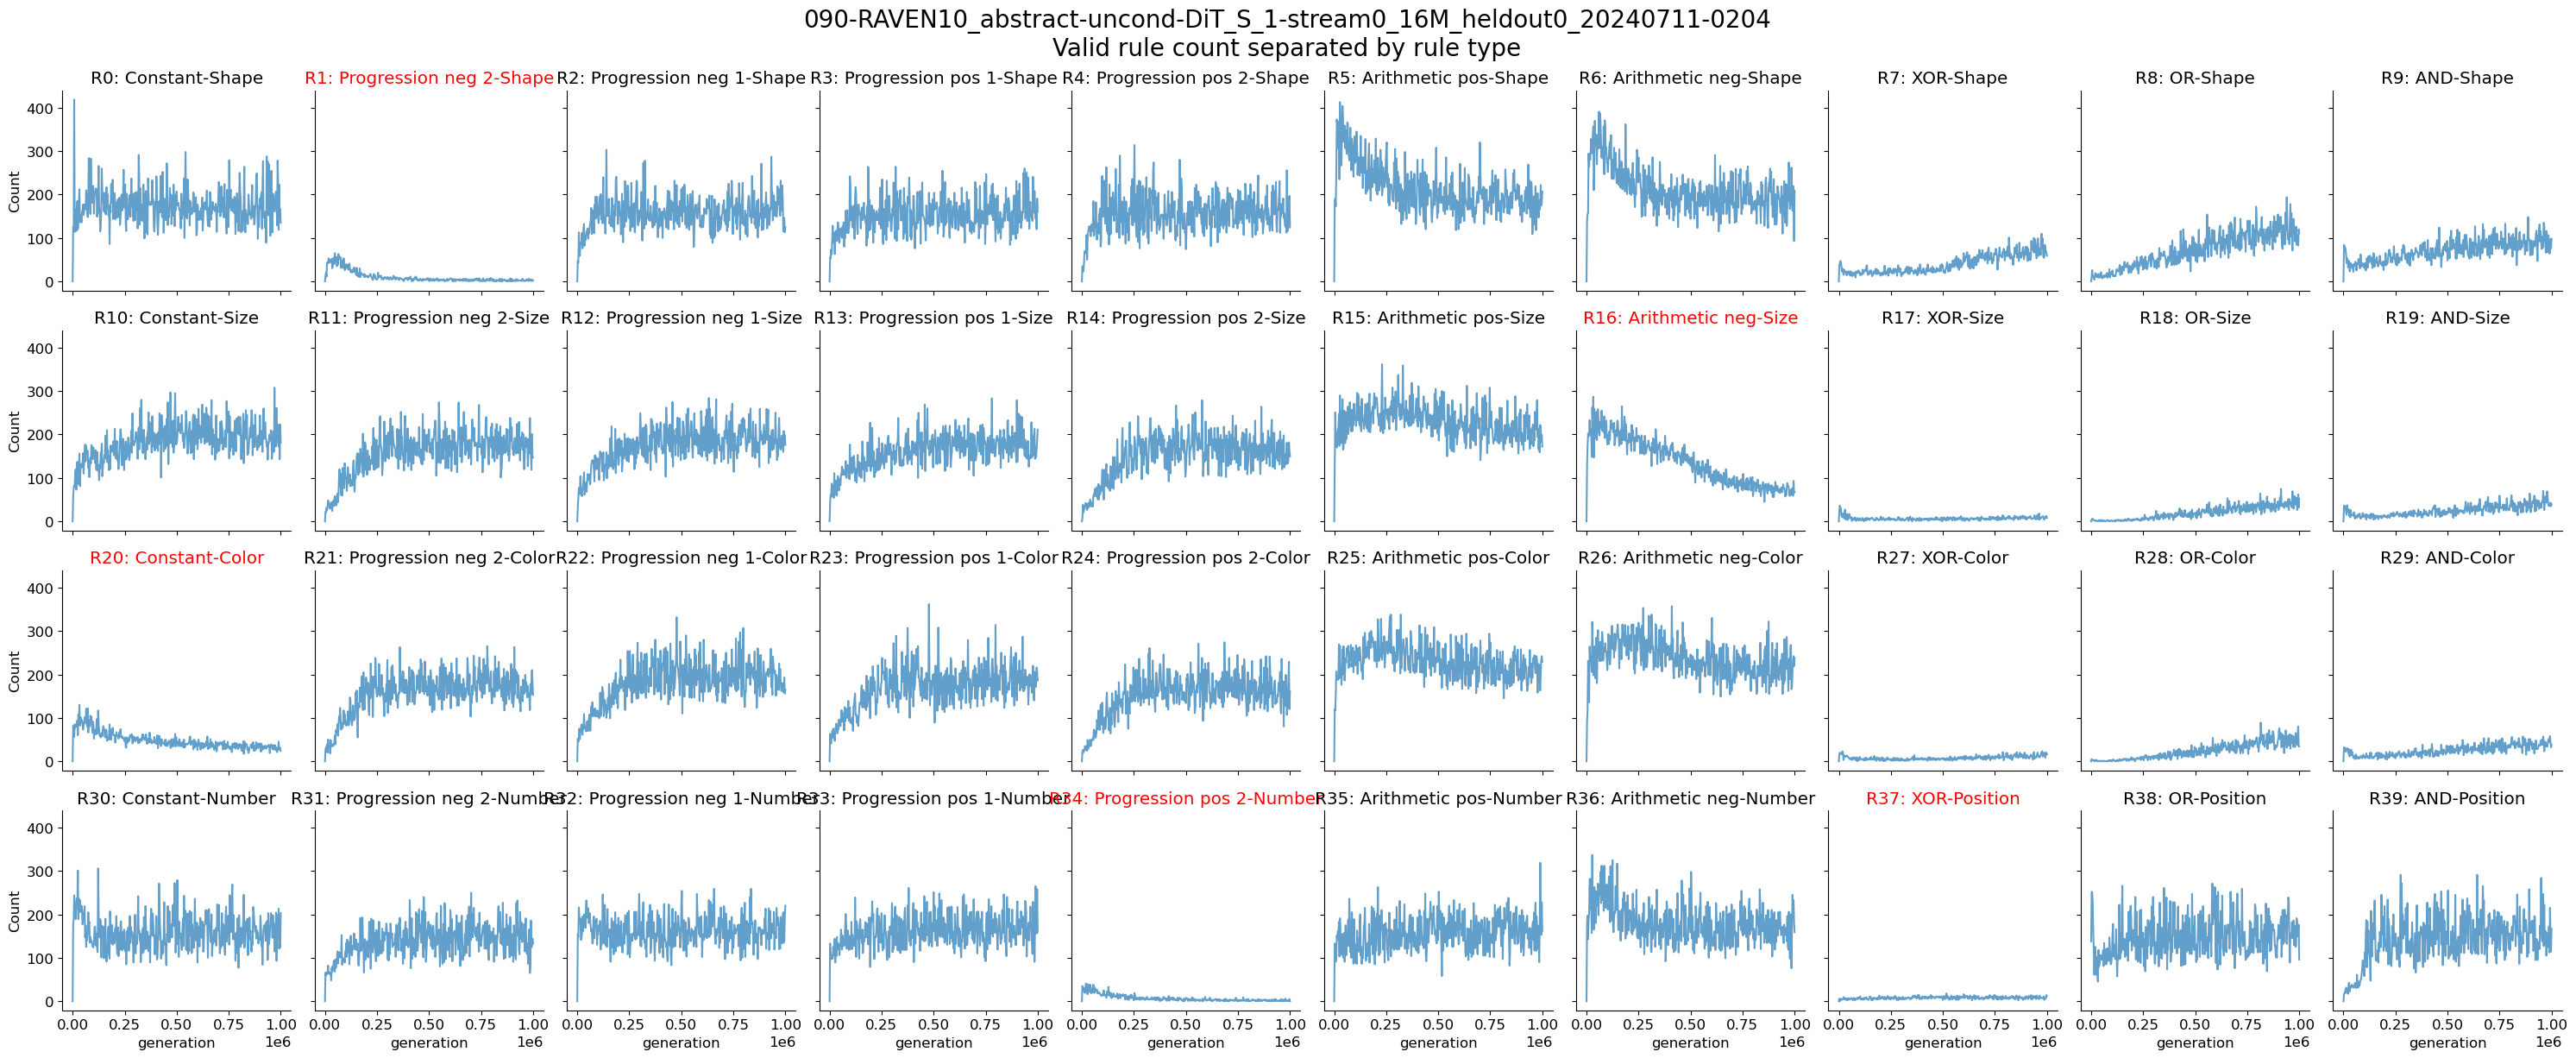

In [48]:
figh, axs = visualize_indiv_rule_dynam(epoch_list, rule_cnt_mat, conv_wid=1, heldout_id=heldout_id,
                        titlestr=f"{expname}\nValid rule count separated by rule type")

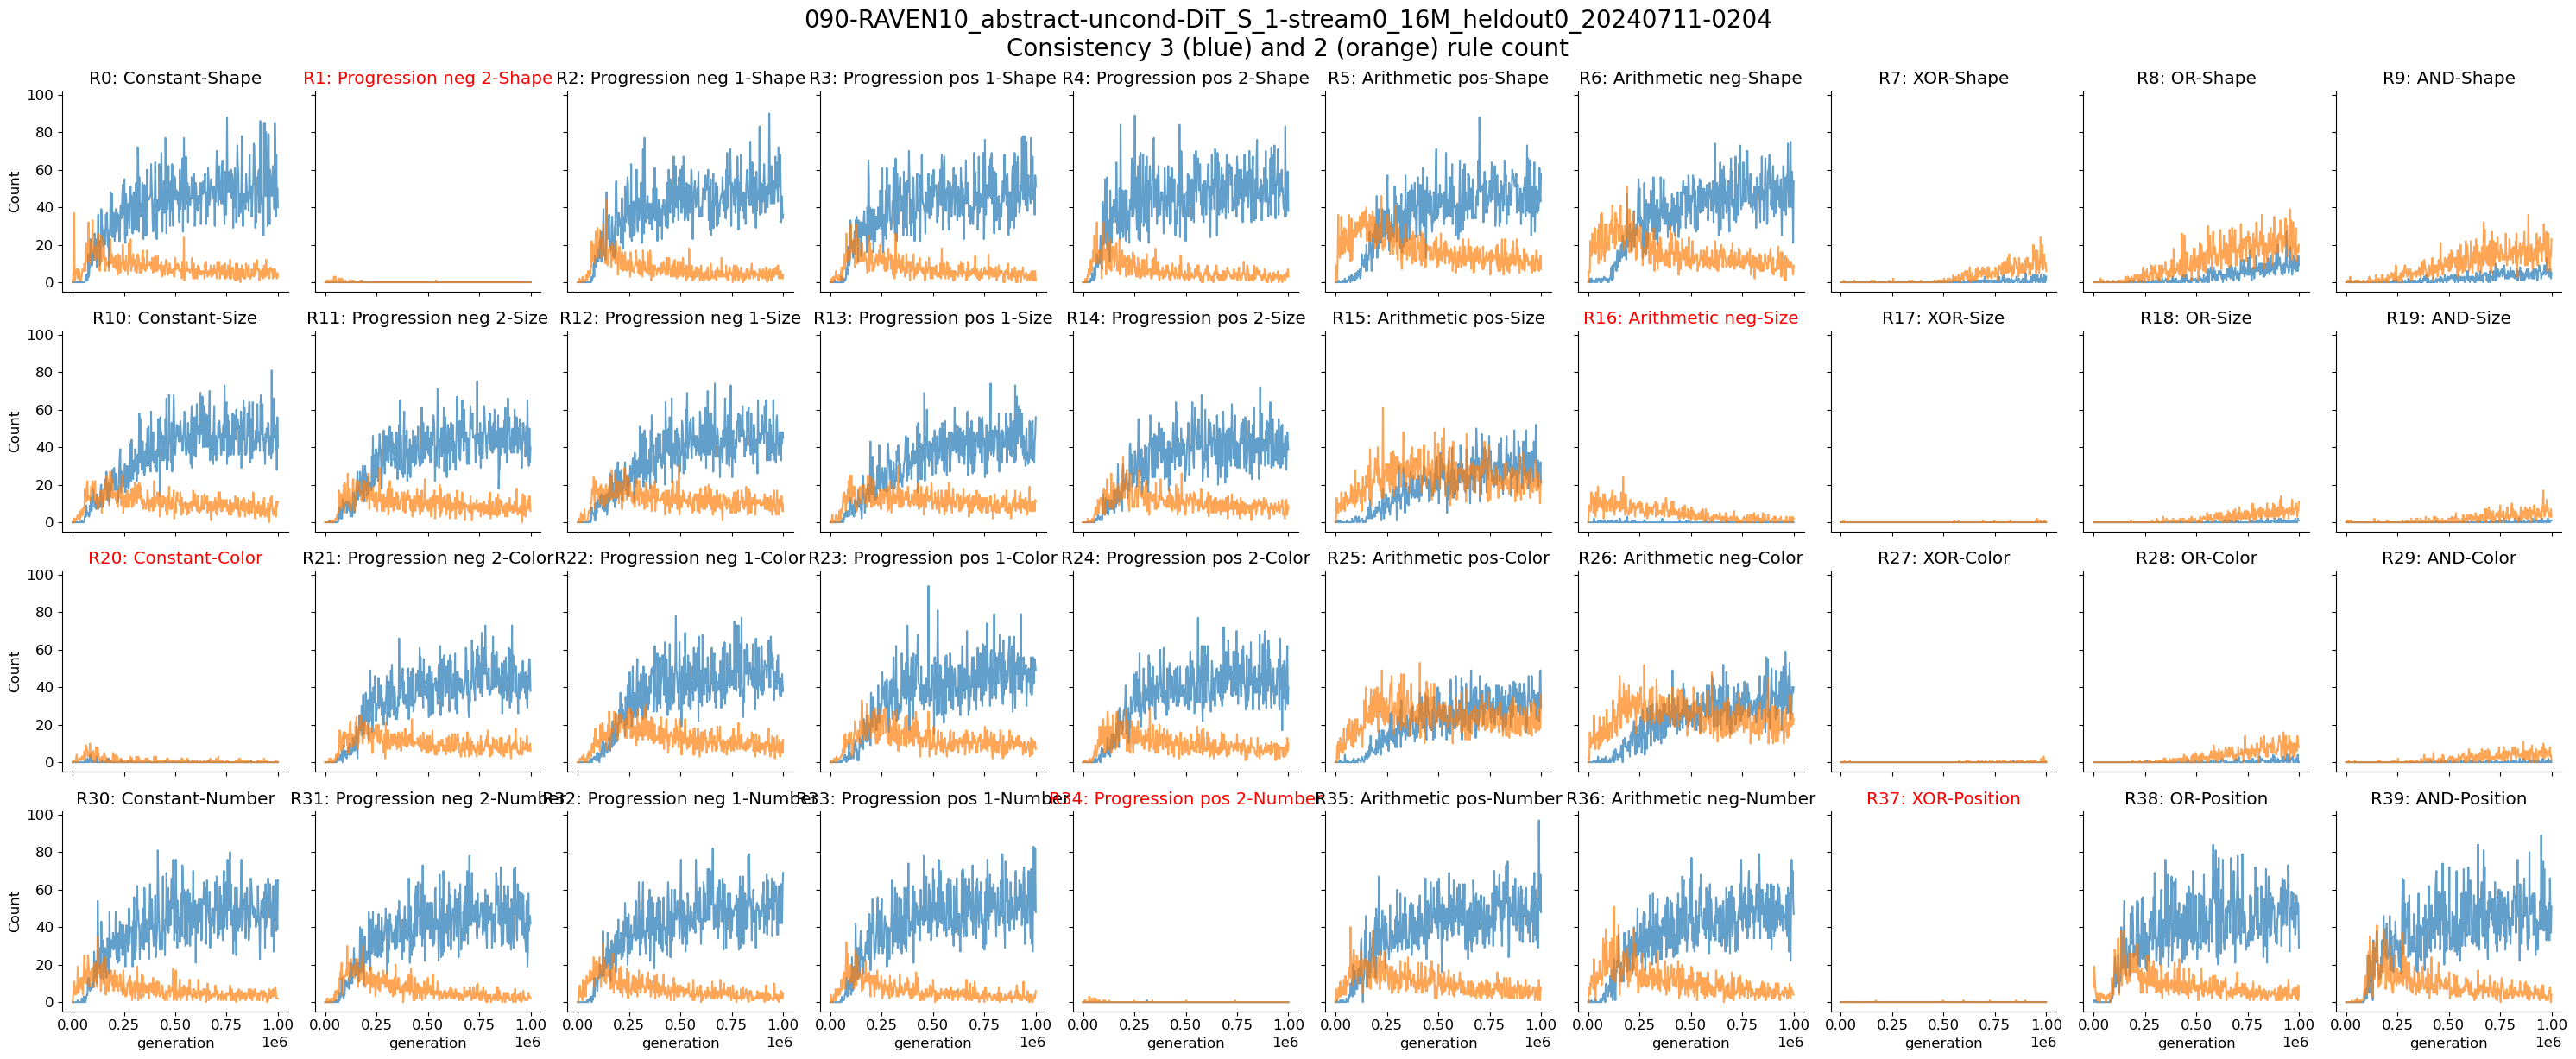

In [50]:
figh, axs = visualize_indiv_rule_dynam(epoch_list, cons3_rule_cnt_mat, conv_wid=1, heldout_id=heldout_id,
                                    titlestr=f"{expname}\nConsistency 3 (blue) and 2 (orange) rule count", )
figh, axs = visualize_indiv_rule_dynam(epoch_list, cons2_rule_cnt_mat, conv_wid=1, heldout_id=heldout_id,
                                    titlestr=f"{expname}\nConsistency 3 (blue) and 2 (orange) rule count", axs=axs)
figh.show()

In [76]:
inpaint_acc_end = df_all.query("epoch == 900000").groupby("rule_id").inpaint_acc.mean()
uncond_c3_cnt_end = cons3_rule_cnt_mat[-10:,].mean(axis=0)
uncond_c3_freq_end = uncond_c3_cnt_end / 2048 * 40
uncond_valid_cnt_end = rule_cnt_mat[-10:,].mean(axis=0)
uncond_valid_freq_end = uncond_valid_cnt_end / 2048 / 3 * 40

In [75]:
from scipy.stats import pearsonr, spearmanr
print("Correlation between inpainting accuracy and rule frequency (valid row)", pearsonr(inpaint_acc_end, uncond_valid_freq_end))
print("Correlation between inpainting accuracy and rule frequency (valid row)", spearmanr(inpaint_acc_end, uncond_valid_freq_end))
print("Correlation between inpainting accuracy and rule frequency (C3 samples)", pearsonr(inpaint_acc_end, uncond_c3_freq_end))
print("Correlation between inpainting accuracy and rule frequency (C3 samples)", spearmanr(inpaint_acc_end, uncond_c3_freq_end))

Correlation between inpainting accuracy and rule frequency (valid row) PearsonRResult(statistic=0.7103929596018, pvalue=2.8235076654793747e-07)
Correlation between inpainting accuracy and rule frequency (valid row) SignificanceResult(statistic=0.6081535575772078, pvalue=3.145436669883189e-05)
Correlation between inpainting accuracy and rule frequency (C3 samples) PearsonRResult(statistic=0.8418130659821885, pvalue=1.0081435935914231e-11)
Correlation between inpainting accuracy and rule frequency (C3 samples) SignificanceResult(statistic=0.7830474187141843, pvalue=2.3540653760066636e-09)


In [68]:
heldout_mask = np.zeros(40, dtype=bool)
heldout_mask[heldout_id] = 1

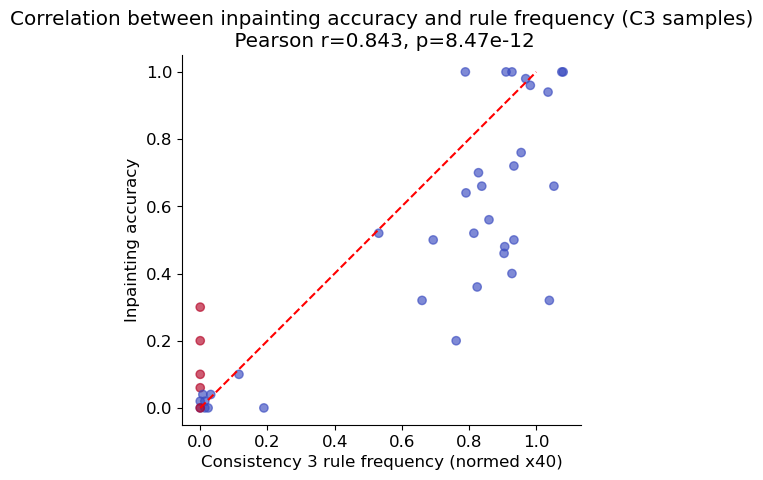

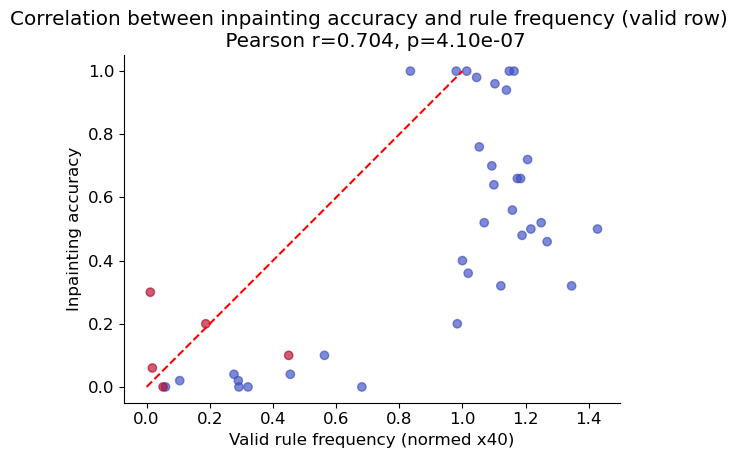

In [104]:
plt.scatter(uncond_c3_freq_end, inpaint_acc_end, alpha=0.65, 
            c=heldout_mask, cmap="coolwarm")
rho, pval = pearsonr(uncond_c3_freq_end, inpaint_acc_end)
# add diagonal line
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("Consistency 3 rule frequency (normed x40)")
plt.ylabel("Inpainting accuracy")
plt.title("Correlation between inpainting accuracy and rule frequency (C3 samples)\n Pearson r={:.3f}, p={:.2e}".format(rho, pval))
plt.axis("image")
saveallforms(figexpdir, "inpainting_acc_vs_c3_freq_corr", plt.gcf())
plt.show()


plt.scatter(uncond_valid_freq_end, inpaint_acc_end, alpha=0.65, 
            c=heldout_mask, cmap="coolwarm")
rho, pval = pearsonr(uncond_valid_freq_end, inpaint_acc_end)
# add diagonal line
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("Valid rule frequency (normed x40)")
plt.ylabel("Inpainting accuracy")
plt.title("Correlation between inpainting accuracy and rule frequency (valid row) \n Pearson r={:.3f}, p={:.2e}".format(rho, pval))
plt.axis("image")
saveallforms(figexpdir, "inpainting_acc_vs_validrow_freq_corr", plt.gcf())
plt.show()


In [17]:
pklpaths = glob(join(outdir, "inpaint_stats_*.pkl"))
for pklpath in pklpaths:
    print(pklpath)
    # extract savestr from pklpath
    savestr = re.search(r"inpaint_stats_(.*).pkl", pklpath).group(1)
    inpaint_stats_df = pd.read_pickle(pklpath)
    

,rule_id,sample_id,inpaint_acc,valid_acc
0,0,50,0.0,1.0
1,0,51,1.0,1.0
2,0,52,0.0,0.0
3,0,53,0.0,0.0
4,0,54,0.0,1.0
...,...,...,...,...
1995,39,95,1.0,1.0
1996,39,96,1.0,1.0
1997,39,97,1.0,1.0
1998,39,98,1.0,1.0


### Sweep across model scale and conditions

In [6]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
figroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_inpainting"
syndir = join(figroot, "synopsis")
os.makedirs(syndir, exist_ok=True)

In [7]:
!echo {exproot}/090-RAVEN10_abstract*

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204


In [8]:
match = glob(join(exproot, "*-RAVEN10_abstract*"))
expdir = match[0]
expname = expdir.split("/")[-1]
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
outdir = join(expdir, "inpainting_results")

In [105]:
df_syn = []
outdir_col = sorted(glob(join(exproot, "*-RAVEN10_abstract*","inpainting_results")))
for outdir in outdir_col:
    # find the parent folder of the outdir using os
    parentdir = os.path.dirname(outdir)
    expname = os.path.basename(parentdir)
    print(expname)
    pklpaths = glob(join(outdir, "inpaint_stats_*.pkl"))
    for pklpath in pklpaths:
        print("- ", os.path.basename(pklpath))
        # extract savestr from pklpath
        savestr = re.search(r"inpaint_stats_(.*).pkl", pklpath).group(1)
        match = re.search(r"inpaint_stats_ep(\d+)_(\d+)_(\d+)_batch(\d+)\.pkl", pklpath)
        epoch, sample_beg, sample_end, batch = match.groups()
        epoch, sample_beg, sample_end, batch = int(epoch), int(sample_beg), int(sample_end), int(batch)
        inpaint_stats_df = pd.read_pickle(pklpath)
        # inpaint_stats_df = pd.read_pickle(join(outdir, f"inpaint_stats_{savestr}.pkl"))
        inpaint_stats_df["epoch"] = epoch
        inpaint_stats_df["expname"] = expname
        df_syn.append(inpaint_stats_df)
        # results_col = pkl.load(open(join(outdir, f"inpaint_results_{savestr}.pkl"), "rb"))
df_syn = pd.concat(df_syn, axis=0)

085-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_20240711-0204
-  inpaint_stats_ep100000_50_100_batch25.pkl
-  inpaint_stats_ep500000_50_100_batch25.pkl
-  inpaint_stats_ep1000000_50_100_batch25.pkl
-  inpaint_stats_ep200000_50_100_batch25.pkl
-  inpaint_stats_ep700000_50_100_batch25.pkl
-  inpaint_stats_ep20000_50_100_batch25.pkl
-  inpaint_stats_ep900000_50_100_batch25.pkl
086-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_20240711-0204
-  inpaint_stats_ep1000000_50_100_batch25.pkl
087-RAVEN10_abstract-uncond-DiT_S_1-stream16M_20240711-0204
-  inpaint_stats_ep1000000_50_100_batch25.pkl
088-RAVEN10_abstract-uncond-DiT_S_1-stream16M_heldout0_20240711-0204
-  inpaint_stats_ep1000000_50_100_batch25.pkl
089-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_heldout0_20240711-0204
-  inpaint_stats_ep1000000_50_100_batch25.pkl
090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204
-  inpaint_stats_ep100000_50_100_batch25.pkl
-  inpaint_stats_ep500000_50_100_batch25.pkl
-  inpaint_stats_e

In [79]:
df_syn.query("epoch==1000000").groupby("expname")["inpaint_acc"].mean()

expname
085-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_20240711-0204              0.5225
086-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_20240711-0204               0.5365
087-RAVEN10_abstract-uncond-DiT_S_1-stream16M_20240711-0204                0.5425
088-RAVEN10_abstract-uncond-DiT_S_1-stream16M_heldout0_20240711-0204       0.4545
089-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_heldout0_20240711-0204      0.4555
090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204     0.4515
091-RAVEN10_abstract-uncond-DiT_B_1-stream16M_20240711-0205                0.5295
092-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_20240711-0205               0.5370
093-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_heldout0_20240711-0205      0.4500
094-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_heldout0_20240711-0205     0.4425
095-RAVEN10_abstract-uncond-DiT_B_1-stream16M_heldout0_20240711-0205       0.4640
096-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_20240711-0205              0.5490
097-RAVE

In [106]:
df_syn["heldout"] = df_syn.expname.map(lambda x: "_heldout0" in x)
df_syn["scale"] = df_syn.expname.map(lambda x: "DiT_B_1" if "DiT_B_1" in x else "DiT_S_1" if "DiT_S_1" in x else None)
df_syn["dataset_size"] = df_syn.expname.map(extract_and_convert)
heldout_ids = [1, 16, 20, 34, 37]
df_syn["heldout_rule"] = df_syn.rule_id.map(lambda x: x in heldout_ids) & df_syn.heldout

df_syn.to_csv(join(syndir, "inpaint_model_epoch_combined.csv"), index=False)

In [82]:
df_syn.groupby("expname").agg({"heldout_rule":"sum"})

,heldout_rule
expname,
085-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_20240711-0204,0
086-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_20240711-0204,0
087-RAVEN10_abstract-uncond-DiT_S_1-stream16M_20240711-0204,0
088-RAVEN10_abstract-uncond-DiT_S_1-stream16M_heldout0_20240711-0204,250
089-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_heldout0_20240711-0204,250
090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204,1750
091-RAVEN10_abstract-uncond-DiT_B_1-stream16M_20240711-0205,0
092-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_20240711-0205,0
093-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_heldout0_20240711-0205,250


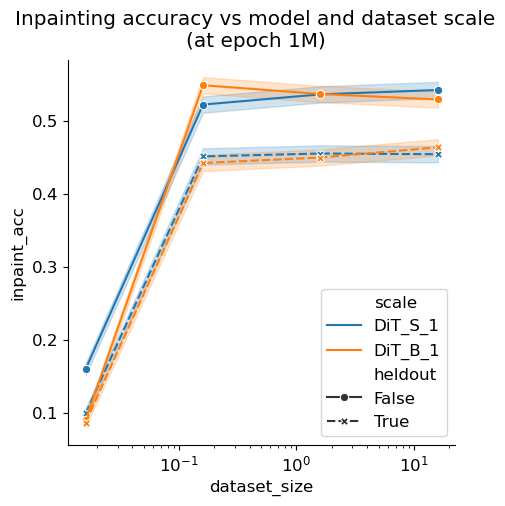

In [113]:
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=df_syn.query("epoch==1000000"), x="dataset_size", 
             y="inpaint_acc", hue="scale", style="heldout", markers=True, errorbar="se")
plt.xscale("log")
plt.suptitle("Inpainting accuracy vs model and dataset scale\n(at epoch 1M)")
saveallforms(syndir, "inpaint_acc_vs_scale_train+heldout_models", figh)

Text(0.5, 0.98, 'Inpainting accuracy vs model and dataset scale\n(at epoch 1M)')

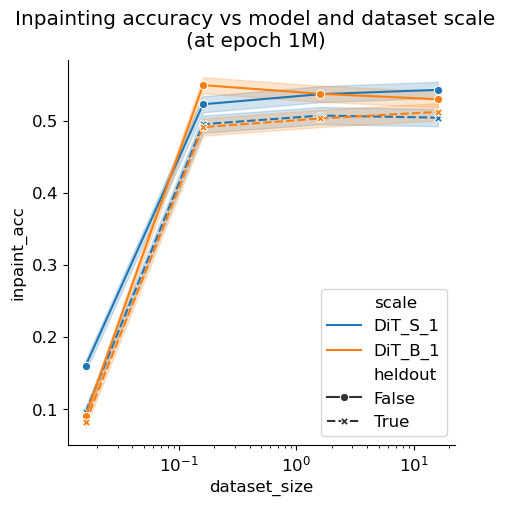

In [119]:
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=df_syn.query("epoch==1000000 and heldout_rule == False"), x="dataset_size", 
             y="inpaint_acc", hue="scale", style="heldout", markers=True, errorbar="se")
plt.xscale("log")
plt.suptitle("Inpainting accuracy vs model and dataset scale\n(at epoch 1M)")
# saveallforms(syndir, "inpaint_acc_vs_scale_train+heldout_models", figh)

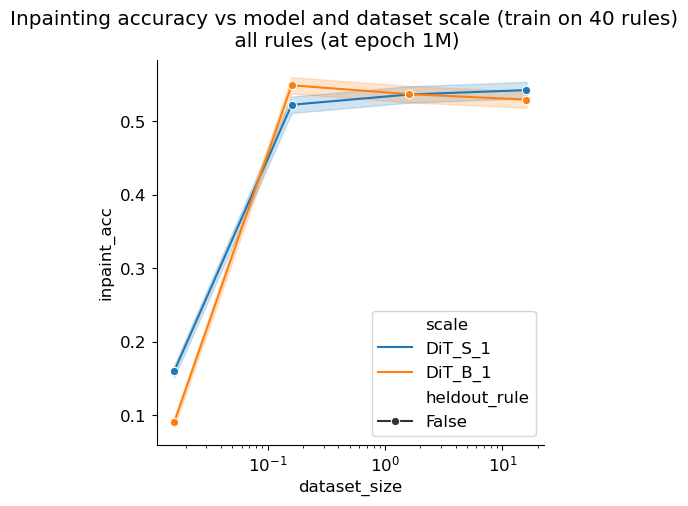

In [114]:
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=df_syn.query("epoch == 1000000 and heldout == False"), x="dataset_size", y="inpaint_acc", style="heldout_rule", hue="scale", markers=True, errorbar="se")
plt.xscale("log")
plt.suptitle("Inpainting accuracy vs model and dataset scale (train on 40 rules)\n all rules (at epoch 1M)")
saveallforms(syndir, "inpaint_acc_vs_scale_allrules_models", figh)

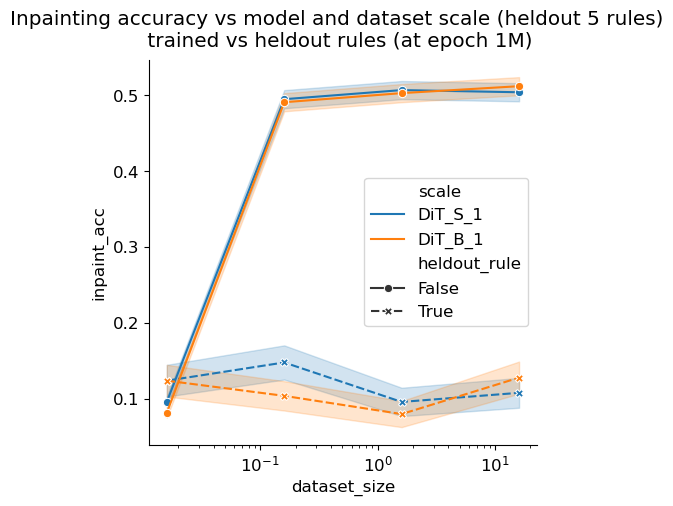

In [116]:
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=df_syn.query("epoch == 1000000 and heldout == True"), x="dataset_size", y="inpaint_acc", hue="scale", style="heldout_rule", markers=True, errorbar="se")
plt.xscale("log")
plt.suptitle("Inpainting accuracy vs model and dataset scale (heldout 5 rules)\n trained vs heldout rules (at epoch 1M)")
saveallforms(syndir, "inpaint_acc_vs_scale_heldout_models_train_vs_heldout_split", figh)


In [18]:
df_syn.query("epoch==1000000").groupby("expname")["inpaint_acc"].mean()

expname
085-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_20240711-0204              0.5225
086-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_20240711-0204               0.5365
087-RAVEN10_abstract-uncond-DiT_S_1-stream16M_20240711-0204                0.5425
088-RAVEN10_abstract-uncond-DiT_S_1-stream16M_heldout0_20240711-0204       0.4545
089-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_heldout0_20240711-0204      0.4555
090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204     0.4515
091-RAVEN10_abstract-uncond-DiT_B_1-stream16M_20240711-0205                0.5295
092-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_20240711-0205               0.5370
093-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_heldout0_20240711-0205      0.4500
094-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_heldout0_20240711-0205     0.4425
095-RAVEN10_abstract-uncond-DiT_B_1-stream16M_heldout0_20240711-0205       0.4640
096-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_20240711-0205              0.5490
097-RAVE

### New batch of held out experiments

In [12]:
df_syn = []
outdir_col = sorted(glob(join(exproot, "*-RAVEN10_abstract*","inpainting_results")))
for outdir in outdir_col:
    # find the parent folder of the outdir using os
    parentdir = os.path.dirname(outdir)
    expname = os.path.basename(parentdir)
    print(expname)
    pklpaths = glob(join(outdir, "inpaint_stats_*.pkl"))
    for pklpath in pklpaths:
        print("- ", os.path.basename(pklpath))
        # extract savestr from pklpath
        savestr = re.search(r"inpaint_stats_(.*).pkl", pklpath).group(1)
        match = re.search(r"inpaint_stats_ep(\d+)_(\d+)_(\d+)_(.*)\.pkl", pklpath)
        epoch, sample_beg, sample_end, sampler_str = match.groups()
        epoch, sample_beg, sample_end, sampler_str = int(epoch), int(sample_beg), int(sample_end), sampler_str
        inpaint_stats_df = pd.read_pickle(pklpath)
        # inpaint_stats_df = pd.read_pickle(join(outdir, f"inpaint_stats_{savestr}.pkl"))
        inpaint_stats_df["epoch"] = epoch
        inpaint_stats_df["expname"] = expname
        inpaint_stats_df["sampler_str"] = sampler_str
        df_syn.append(inpaint_stats_df)
        # results_col = pkl.load(open(join(outdir, f"inpaint_results_{savestr}.pkl"), "rb"))
df_syn = pd.concat(df_syn, axis=0)

085-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_20240711-0204
-  inpaint_stats_ep100000_50_100_batch25.pkl
-  inpaint_stats_ep500000_50_100_batch25.pkl
-  inpaint_stats_ep1000000_50_100_batch25.pkl
-  inpaint_stats_ep200000_50_100_batch25.pkl
-  inpaint_stats_ep700000_50_100_batch25.pkl
-  inpaint_stats_ep20000_50_100_batch25.pkl
-  inpaint_stats_ep900000_50_100_batch25.pkl
086-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_20240711-0204
-  inpaint_stats_ep1000000_50_100_batch25.pkl
087-RAVEN10_abstract-uncond-DiT_S_1-stream16M_20240711-0204
-  inpaint_stats_ep1000000_50_100_batch25.pkl
088-RAVEN10_abstract-uncond-DiT_S_1-stream16M_heldout0_20240711-0204
-  inpaint_stats_ep1000000_50_100_batch25.pkl
089-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_heldout0_20240711-0204
-  inpaint_stats_ep1000000_50_100_batch25.pkl
090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204
-  inpaint_stats_ep1000000_50_100_batch25_step10.pkl
-  inpaint_stats_ep1000000_50_100_batch25_step250.pkl
-

In [35]:
# df_syn["heldout"] = df_syn.expname.map(lambda x: "_heldout0" in x)
df_syn["scale"] = df_syn.expname.map(lambda x: "DiT_B_1" if "DiT_B_1" in x else "DiT_S_1" if "DiT_S_1" in x else None)
df_syn["dataset_size"] = df_syn.expname.map(extract_and_convert)
# heldout_ids = [1, 16, 20, 34, 37]
# df_syn["heldout_rule"] = df_syn.rule_id.map(lambda x: x in heldout_ids) & df_syn.heldout

df_syn.to_csv(join(syndir, "inpaint_model_epoch_combined_update.csv"), index=False)

In [15]:
df_syn.expname.unique()

array(['085-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_20240711-0204',
       '086-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_20240711-0204',
       '087-RAVEN10_abstract-uncond-DiT_S_1-stream16M_20240711-0204',
       '088-RAVEN10_abstract-uncond-DiT_S_1-stream16M_heldout0_20240711-0204',
       '089-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_heldout0_20240711-0204',
       '090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204',
       '091-RAVEN10_abstract-uncond-DiT_B_1-stream16M_20240711-0205',
       '092-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_20240711-0205',
       '093-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_heldout0_20240711-0205',
       '094-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_heldout0_20240711-0205',
       '095-RAVEN10_abstract-uncond-DiT_B_1-stream16M_heldout0_20240711-0205',
       '096-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_20240711-0205',
       '097-RAVEN10_abstract-uncond-DiT_S_1-stream0_016M_20240816-0049',
       '098-RAVEN10_a

In [16]:
df_syn.columns

Index(['rule_id', 'sample_id', 'inpaint_acc', 'valid_acc', 'epoch', 'expname',
       'sampler_str', 'scale', 'dataset_size'],
      dtype='object')

In [34]:
syndir

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_inpainting/synopsis'

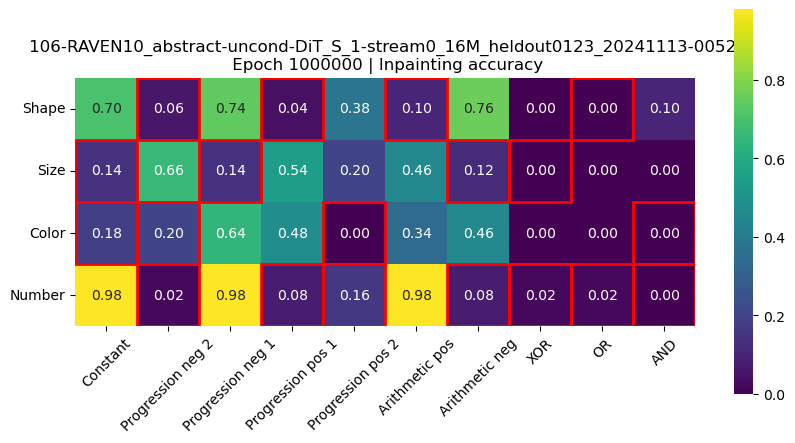

In [33]:
from stats_plot_utils import plot_rule_heatmap
import json
expname = "106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0123_20241113-0052"
epoch = 1000000
config = json.load(open(join(exproot, expname, "args.json"), "r"))
heldout_ids = config["heldout_ids"]

acc_tab = df_syn.query(f"expname == '{expname}' and epoch == {epoch}").\
    groupby("rule_id").agg({"inpaint_acc": "mean"})

figh = plot_rule_heatmap(acc_tab.inpaint_acc.values.reshape(4, 10), heldout_rules=heldout_ids,
                         title=f"{expname} \n Epoch {epoch} | Inpainting accuracy")
saveallforms(syndir, f"inpainting_acc_rule_heatmap_epoch{epoch}_{expname}", figh)

In [26]:
!ls /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0123_20241113-0052/

args.json    dataset_idx.pkl	 log.txt	  samples
checkpoints  inpainting_results  repr_classifier  tensorboard_logs
